# FEMTO Bearing Failure Prediction with RUL Calculation

This notebook processes the FEMTO bearing dataset from the IEEE PHM 2012 Prognostic Challenge. It includes data loading, preprocessing, feature engineering to calculate Remaining Useful Life (RUL), visualization, and model training for bearing failure prediction.

## 1. Import Libraries

In [1]:
# Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import os
import glob
import re
import subprocess

# Signal processing libraries
from scipy import stats
from scipy.signal import butter, filtfilt
from scipy.fft import fft

# Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

# Set plotting style
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

## 2. Data Loading and Combination

First, we'll use the `combine_femto_data.py` script to combine all the FEMTO bearing dataset files into a single CSV file. This script processes the accelerometer and temperature data from each bearing folder and calculates the RUL values.

In [2]:
# Define the path to the FEMTO bearing dataset


# data_folder = "data/raw"  # Update this path
# output_csv = "combined_bearing_data.csv"

# # Check if the data folder exists
# if not os.path.exists(data_folder):
#     print(f"Error: Data folder {data_folder} does not exist.")
#     print("Please update the 'data_folder' variable with the correct path.")
# else:
#     # Run the data combination script
#     script_path = "./combine_femto_data.py"
    
#     if not os.path.exists(script_path):
#         script_path = "/home/ubuntu/bearing_rul_prediction/combine_femto_data.py"
    
#     if not os.path.exists(script_path):
#         print(f"Error: Script {script_path} not found.")
#     else:
#         print(f"Combining data from {data_folder}...")
#         try:
#             result = subprocess.run(["python", script_path, data_folder, output_csv], 
#                                    capture_output=True, text=True, check=True)
#             print(result.stdout)
#             print(f"Data combined successfully and saved to {output_csv}")
#         except subprocess.CalledProcessError as e:
#             print(f"Error running the script: {e}")
#             print(f"Script output: {e.stdout}")
#             print(f"Script error: {e.stderr}")

### Load the Combined Data

Now we'll load the combined data from the CSV file.

In [3]:
def load_combined_data(csv_path):
    """
    Load the combined bearing data from a CSV file.
    
    Parameters:
    csv_path (str): Path to the combined CSV file
    
    Returns:
    pd.DataFrame: DataFrame containing the combined bearing data
    """
    try:
        df = pd.read_csv(csv_path)
        print(f"Loaded {len(df)} records from {csv_path}")
        return df
    except Exception as e:
        print(f"Error loading data from {csv_path}: {e}")
        return None

# Load the combined data
if os.path.exists(r"E:\Machine Learning\CodE\2. Projects\Ai prediction\data\raw\combined_bearing_data.csv"):  # Update this path to where your CSV is located
    bearing_data = load_combined_data(r"E:\Machine Learning\CodE\2. Projects\Ai prediction\data\raw\combined_bearing_data.csv")
    if bearing_data is not None:
        # Display the first few rows
        bearing_data.head()
    else:
        print("No data loaded. Please check the CSV file.")
else:
    print(f"Error: Combined data file {output_csv} not found.")
    print("Please run the data combination script first.")

Loaded 21493 records from E:\Machine Learning\CodE\2. Projects\Ai prediction\data\raw\combined_bearing_data.csv


## 3. Data Exploration

Let's explore the combined data to understand its structure and characteristics.

In [4]:
def explore_data(df):
    """
    Explore the combined bearing data.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing the combined bearing data
    """
    if df is None or df.empty:
        print("No data to explore")
        return
    
    # Display basic information
    print("Data shape:", df.shape)
    print("\nData types:")
    print(df.dtypes)
    print("\nSummary statistics:")
    print(df.describe())
    
    # Check for missing values
    print("\nMissing values:")
    print(df.isnull().sum())
    
    # Count unique bearings
    print("\nUnique BearingIDs:")
    print(df['BearingID'].unique())
    print(f"Total unique bearings: {df['BearingID'].nunique()}")
    
    # Count records per bearing
    print("\nRecords per bearing:")
    bearing_counts = df.groupby('BearingID').size()
    print(bearing_counts)
    
    # Convert Timestamp to datetime for time-based analysis
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    
    # Calculate time span for each bearing
    print("\nTime span per bearing:")
    for bearing_id, group in df.groupby('BearingID'):
        time_span = group['Timestamp'].max() - group['Timestamp'].min()
        print(f"Bearing {bearing_id}: {time_span}")
    
    # Convert back to string format
    df['Timestamp'] = df['Timestamp'].dt.strftime('%m/%d/%Y %H:%M')

# Explore the data if available
if 'bearing_data' in locals() and bearing_data is not None:
    explore_data(bearing_data)

Data shape: (21493, 9)

Data types:
BearingID          int64
Timestamp         object
RadialForce      float64
RotationSpeed    float64
Torque           float64
HorizontalAcc    float64
VerticalAcc      float64
Temperature      float64
RUL              float64
dtype: object

Summary statistics:
          BearingID   RadialForce  RotationSpeed        Torque  HorizontalAcc  \
count  21493.000000  21493.000000   21493.000000  21493.000000   21493.000000   
mean       3.647374   4174.727980    1721.206937     42.618758       0.001234   
std        1.963164    315.998222     106.055403      4.000580       0.020964   
min        1.000000   3786.610609    1420.819146     31.520629      -0.602544   
25%        2.000000   3990.105533    1647.923127     39.620250      -0.008912   
50%        3.000000   4050.661787    1779.386198     41.814896       0.001312   
75%        5.000000   4205.415638    1803.647430     45.263960       0.011445   
max        7.000000   5167.292644    1877.947446     56.

## 4. Data Preprocessing

In this section, we'll preprocess the loaded data to prepare it for feature engineering and model training.

In [5]:
def preprocess_data(df):
    """
    Preprocess the combined bearing data.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing the combined bearing data
    
    Returns:
    pd.DataFrame: Preprocessed DataFrame
    """
    if df is None or df.empty:
        print("No data to preprocess")
        return None
    
    # Make a copy to avoid modifying the original DataFrame
    processed_df = df.copy()
    
    # Convert Timestamp to datetime if it's not already
    if 'Timestamp' in processed_df.columns and not pd.api.types.is_datetime64_any_dtype(processed_df['Timestamp']):
        try:
            processed_df['Timestamp'] = pd.to_datetime(processed_df['Timestamp'])
        except Exception as e:
            print(f"Error converting Timestamp to datetime: {e}")
            # If conversion fails, create a new timestamp column based on row index
            processed_df['Timestamp'] = pd.date_range(start='1/1/2023', periods=len(processed_df), freq='5min')
    
    # Handle missing values
    numeric_columns = processed_df.select_dtypes(include=[np.number]).columns
    processed_df[numeric_columns] = processed_df[numeric_columns].fillna(processed_df[numeric_columns].mean())
    
    # Remove outliers using IQR method
    for col in numeric_columns:
        if col == 'BearingID':  # Skip BearingID
            continue
        
        Q1 = processed_df[col].quantile(0.25)
        Q3 = processed_df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Replace outliers with bounds
        processed_df.loc[processed_df[col] < lower_bound, col] = lower_bound
        processed_df.loc[processed_df[col] > upper_bound, col] = upper_bound
    
    # Sort by BearingID and Timestamp
    processed_df = processed_df.sort_values(['BearingID', 'Timestamp']).reset_index(drop=True)
    
    # Format Timestamp to match the example format (1/1/2023 0:00)
    processed_df['Timestamp'] = processed_df['Timestamp'].dt.strftime('%m/%d/%Y %H:%M')
    
    return processed_df

# Preprocess the data if available
if 'bearing_data' in locals() and bearing_data is not None:
    preprocessed_data = preprocess_data(bearing_data)
    if preprocessed_data is not None:
        # Display the first few rows
        preprocessed_data.head()
    else:
        print("No preprocessed data available.")

## 5. Feature Engineering

In this section, we'll extract additional features from the preprocessed data to improve the RUL prediction.

In [6]:
def extract_features(df):
    """
    Extract additional features from the preprocessed data.
    
    Parameters:
    df (pd.DataFrame): Preprocessed DataFrame
    
    Returns:
    pd.DataFrame: DataFrame with additional features
    """
    if df is None or df.empty:
        print("No data for feature extraction")
        return None
    
    # Make a copy to avoid modifying the original DataFrame
    features_df = df.copy()
    
    # Convert Timestamp back to datetime for feature extraction
    features_df['Timestamp'] = pd.to_datetime(features_df['Timestamp'])
    
    # Group by BearingID to process each bearing separately
    grouped = features_df.groupby('BearingID')
    
    # Initialize lists to store the results
    result_rows = []
    
    for bearing_id, group in grouped:
        # Sort by timestamp
        group = group.sort_values('Timestamp')
        
        # Calculate time-based features
        group['TimeDelta'] = (group['Timestamp'] - group['Timestamp'].iloc[0]).dt.total_seconds() / 3600  # hours
        
        # Calculate rolling statistics for accelerometer data
        window_size = 3  # Adjust as needed
        
        for col in ['HorizontalAcc', 'VerticalAcc']:
            group[f'{col}_RollingMean'] = group[col].rolling(window=window_size, min_periods=1).mean()
            group[f'{col}_RollingStd'] = group[col].rolling(window=window_size, min_periods=1).std()
            group[f'{col}_RollingMax'] = group[col].rolling(window=window_size, min_periods=1).max()
            group[f'{col}_RollingMin'] = group[col].rolling(window=window_size, min_periods=1).min()
        
        # Calculate rate of change for temperature
        group['Temperature_RoC'] = group['Temperature'].diff() / group['TimeDelta'].diff()
        group['Temperature_RoC'] = group['Temperature_RoC'].fillna(0)
        
        # Calculate combined vibration features
        group['VibrationMagnitude'] = np.sqrt(group['HorizontalAcc']**2 + group['VerticalAcc']**2)
        group['VibrationRatio'] = group['HorizontalAcc'] / group['VerticalAcc'].replace(0, 1e-10)
        
        # Add the processed group to the results
        result_rows.append(group)
    
    # Combine all processed groups
    result_df = pd.concat(result_rows, ignore_index=True)
    
    # Convert Timestamp back to string format
    result_df['Timestamp'] = result_df['Timestamp'].dt.strftime('%m/%d/%Y %H:%M')
    
    return result_df

# Extract features if preprocessed data is available
if 'preprocessed_data' in locals() and preprocessed_data is not None:
    features_data = extract_features(preprocessed_data)
    if features_data is not None:
        # Display the first few rows
        features_data.head()
    else:
        print("No feature data available.")

## 6. Data Visualization

In this section, we'll create visualizations to explore the data and understand the relationships between different features and RUL.

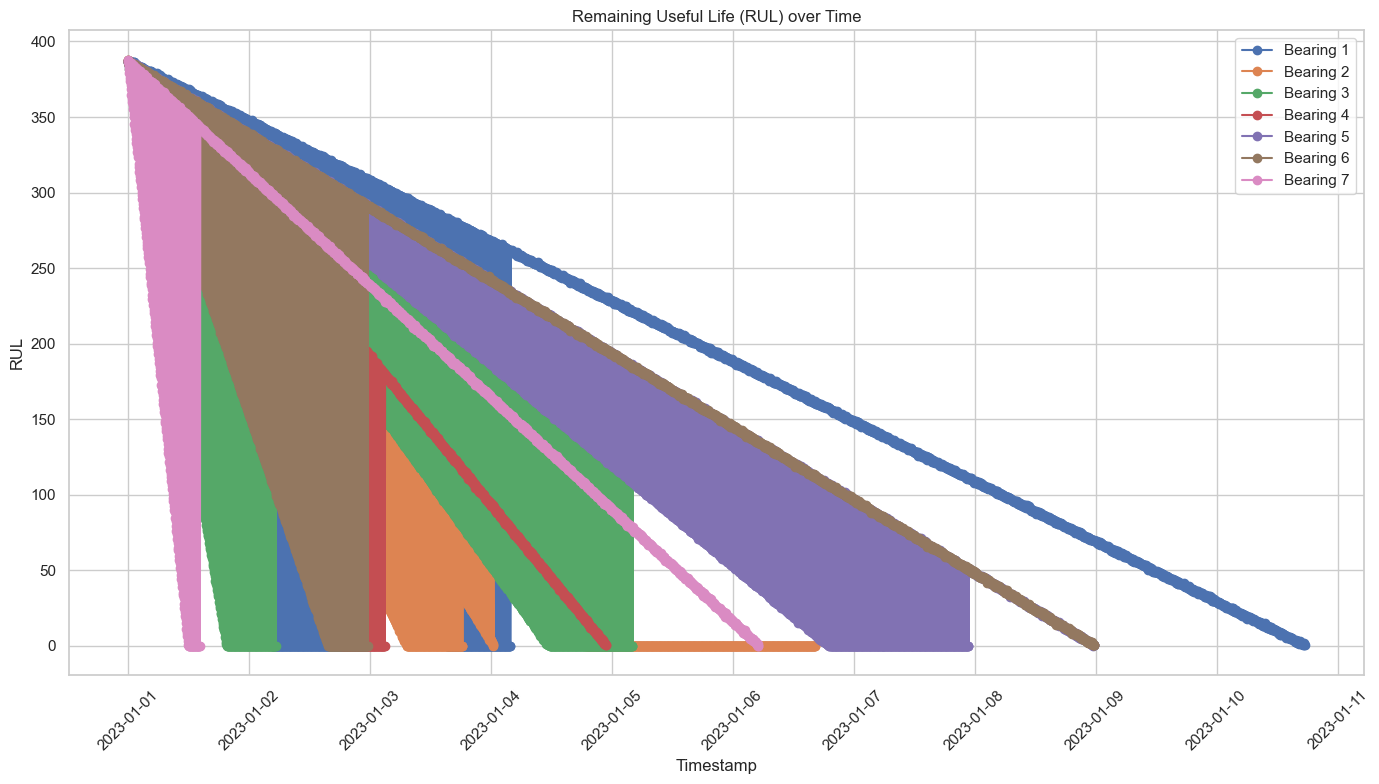

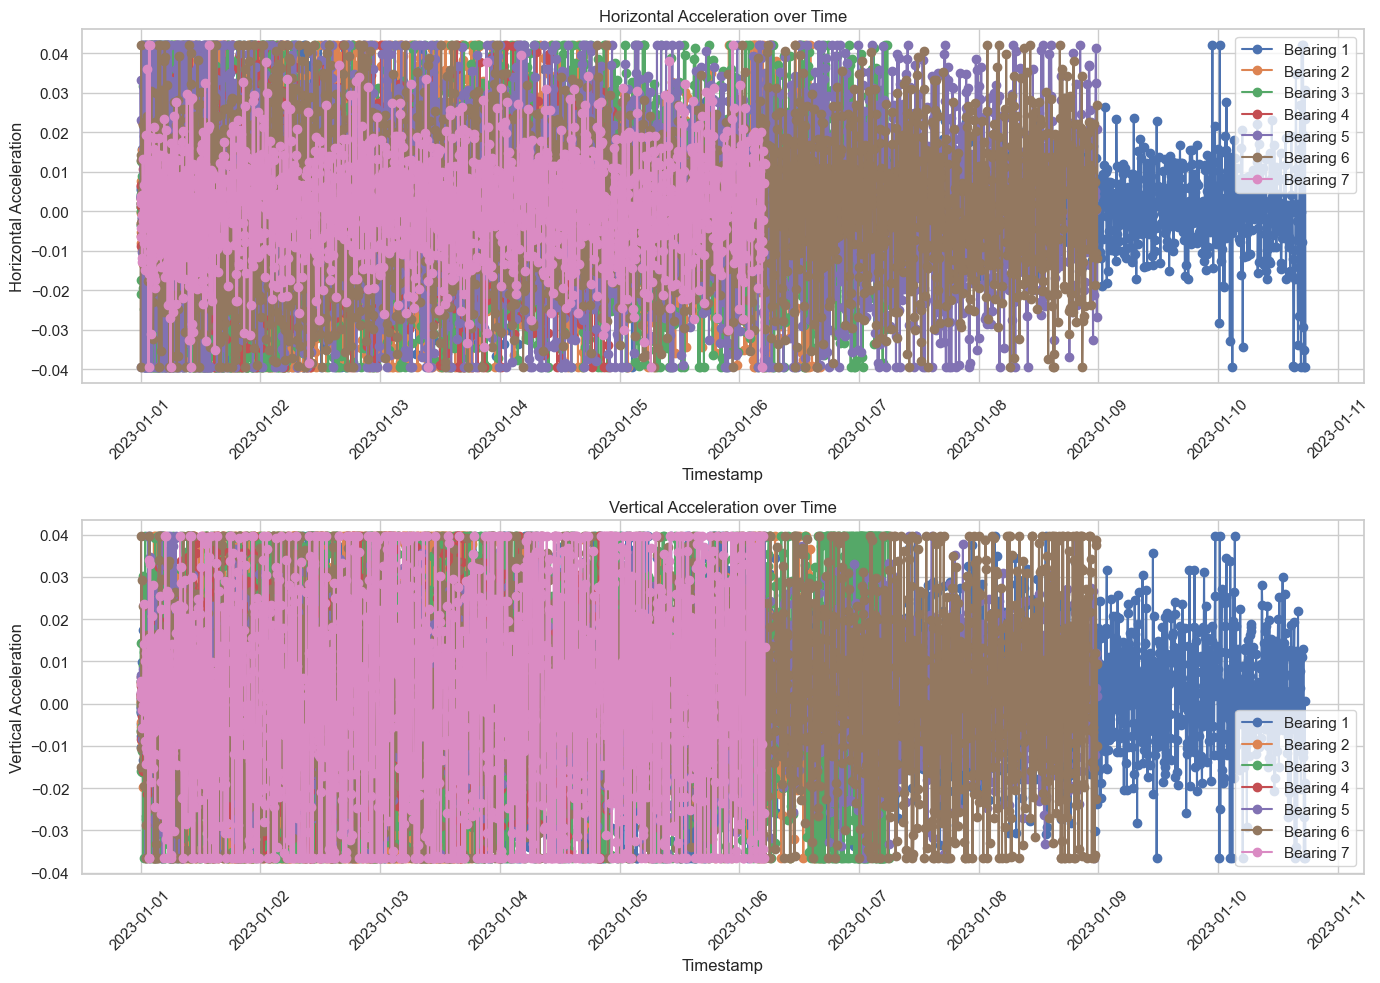

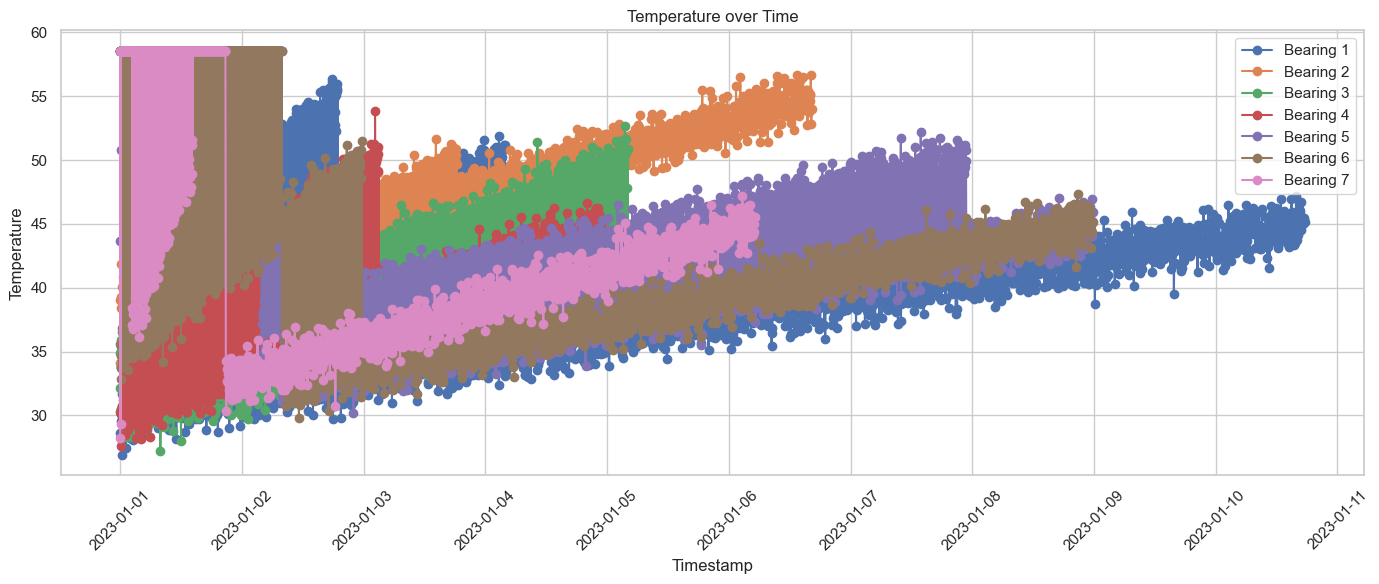

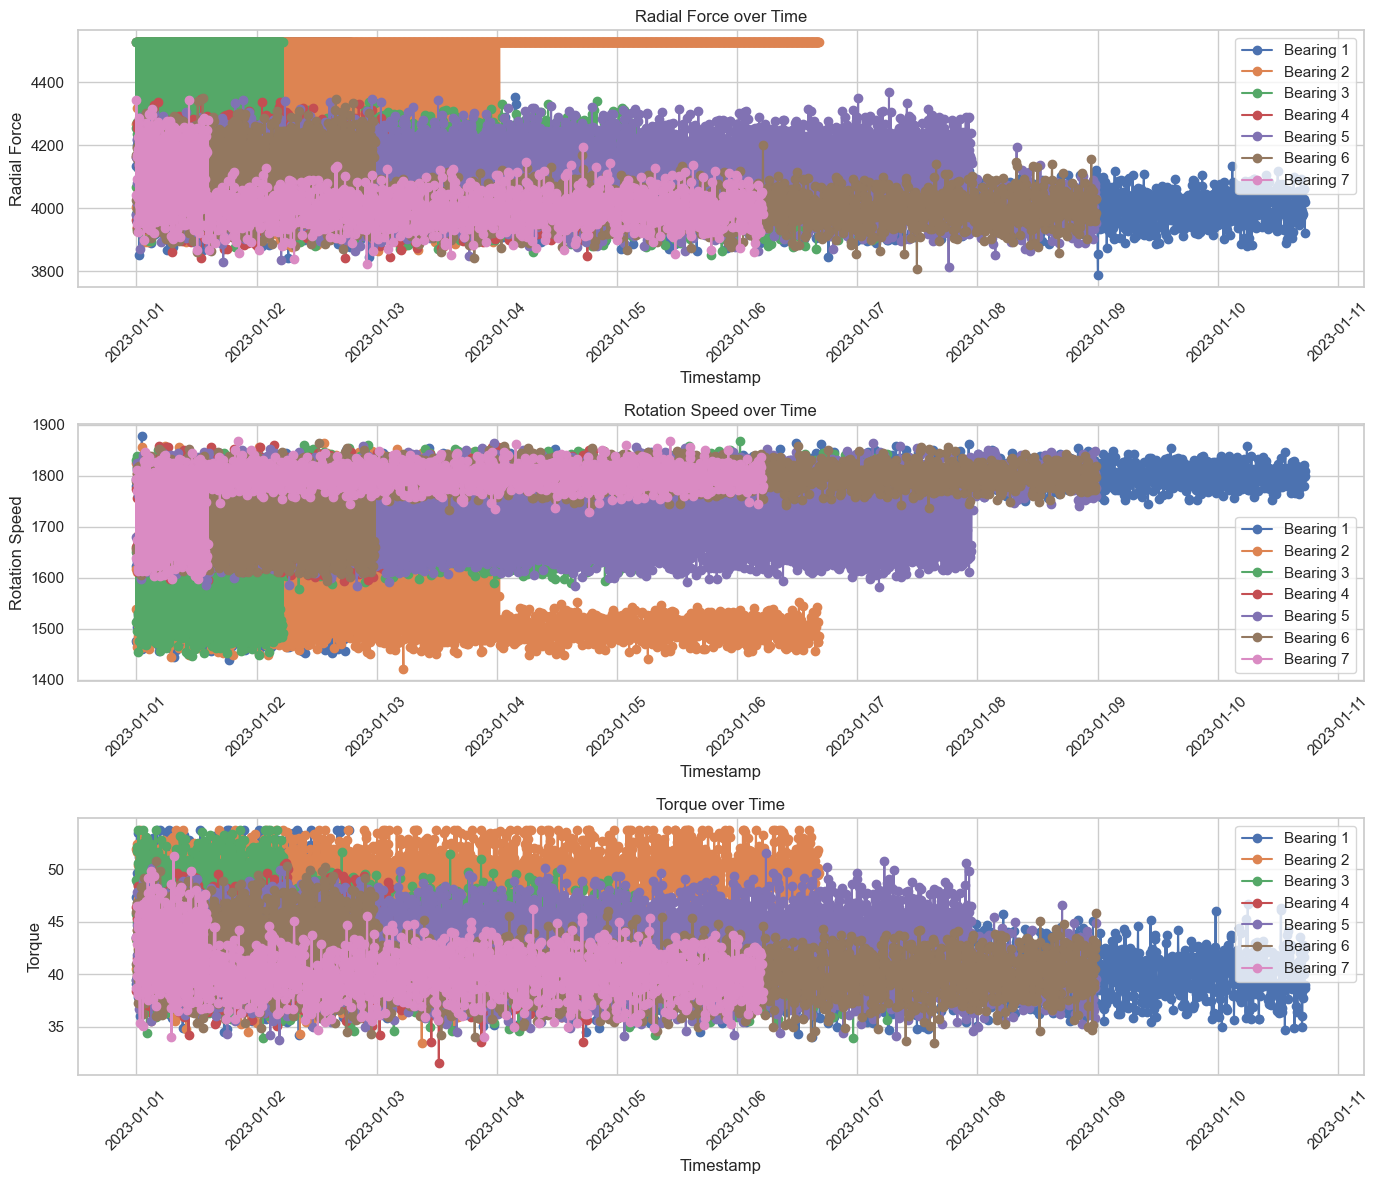

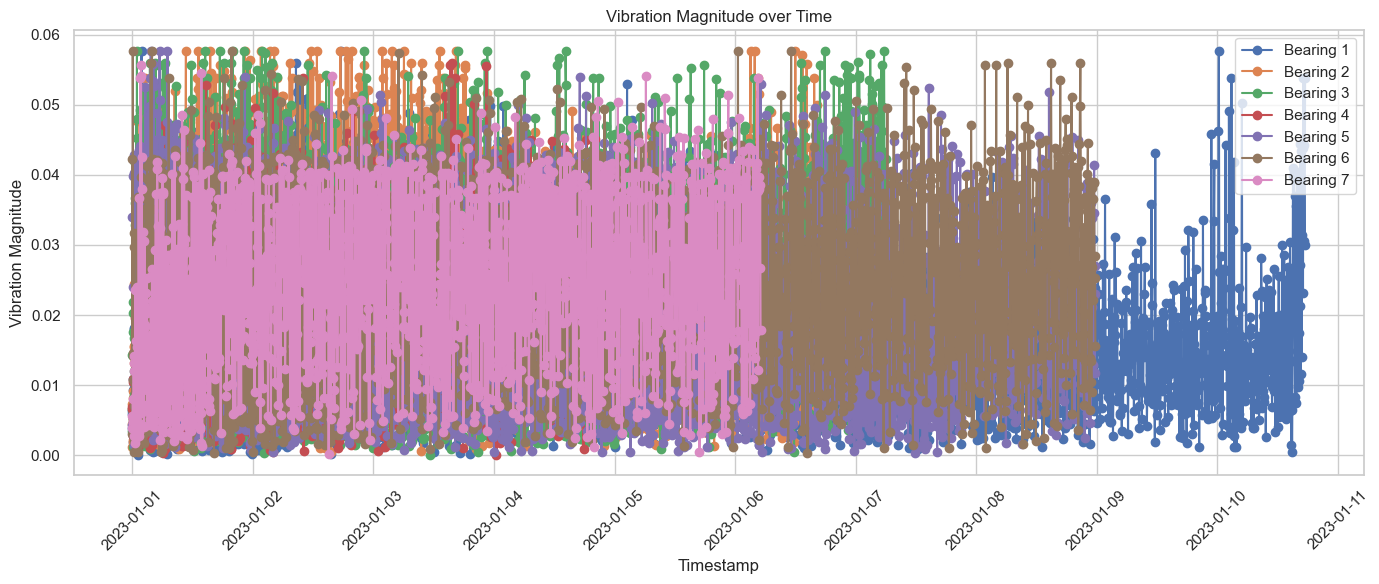

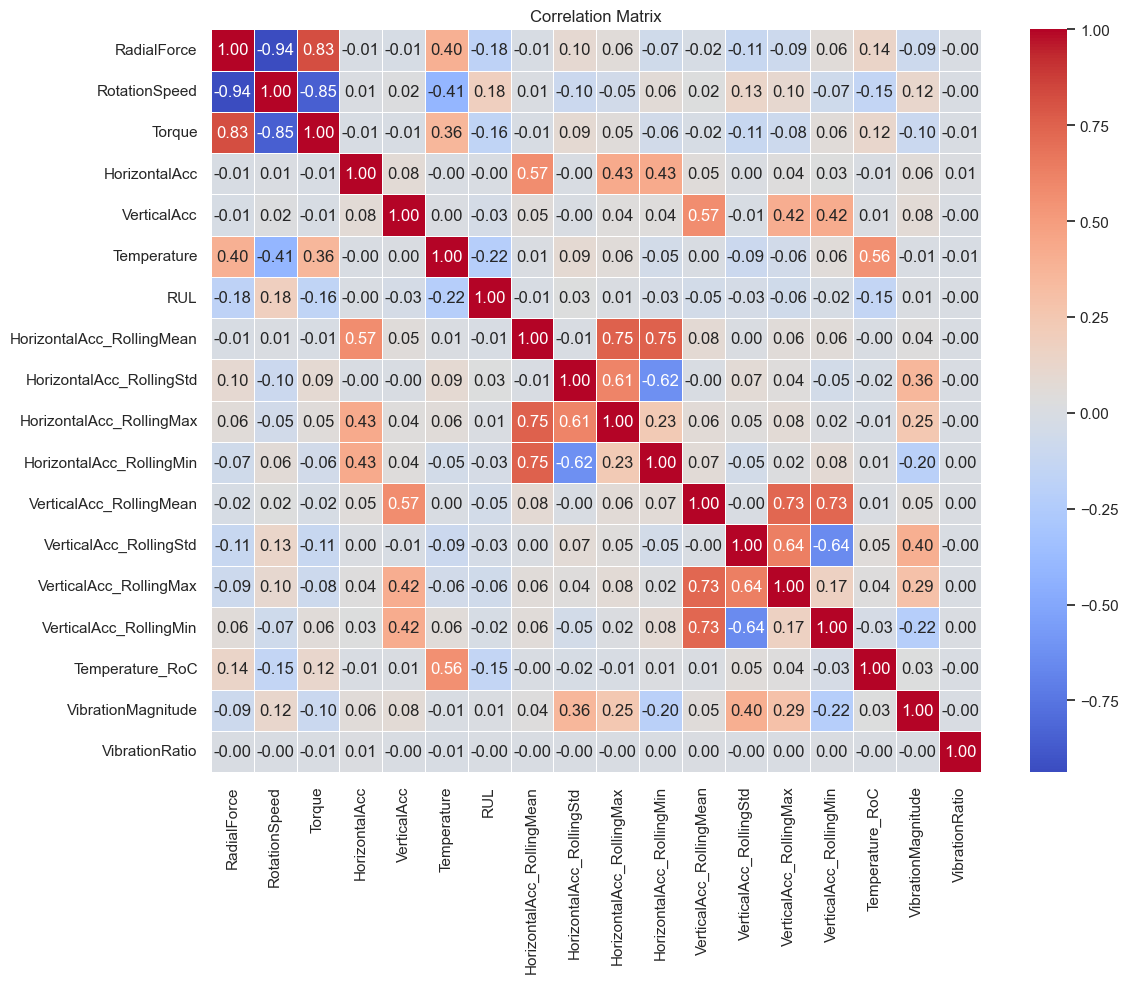

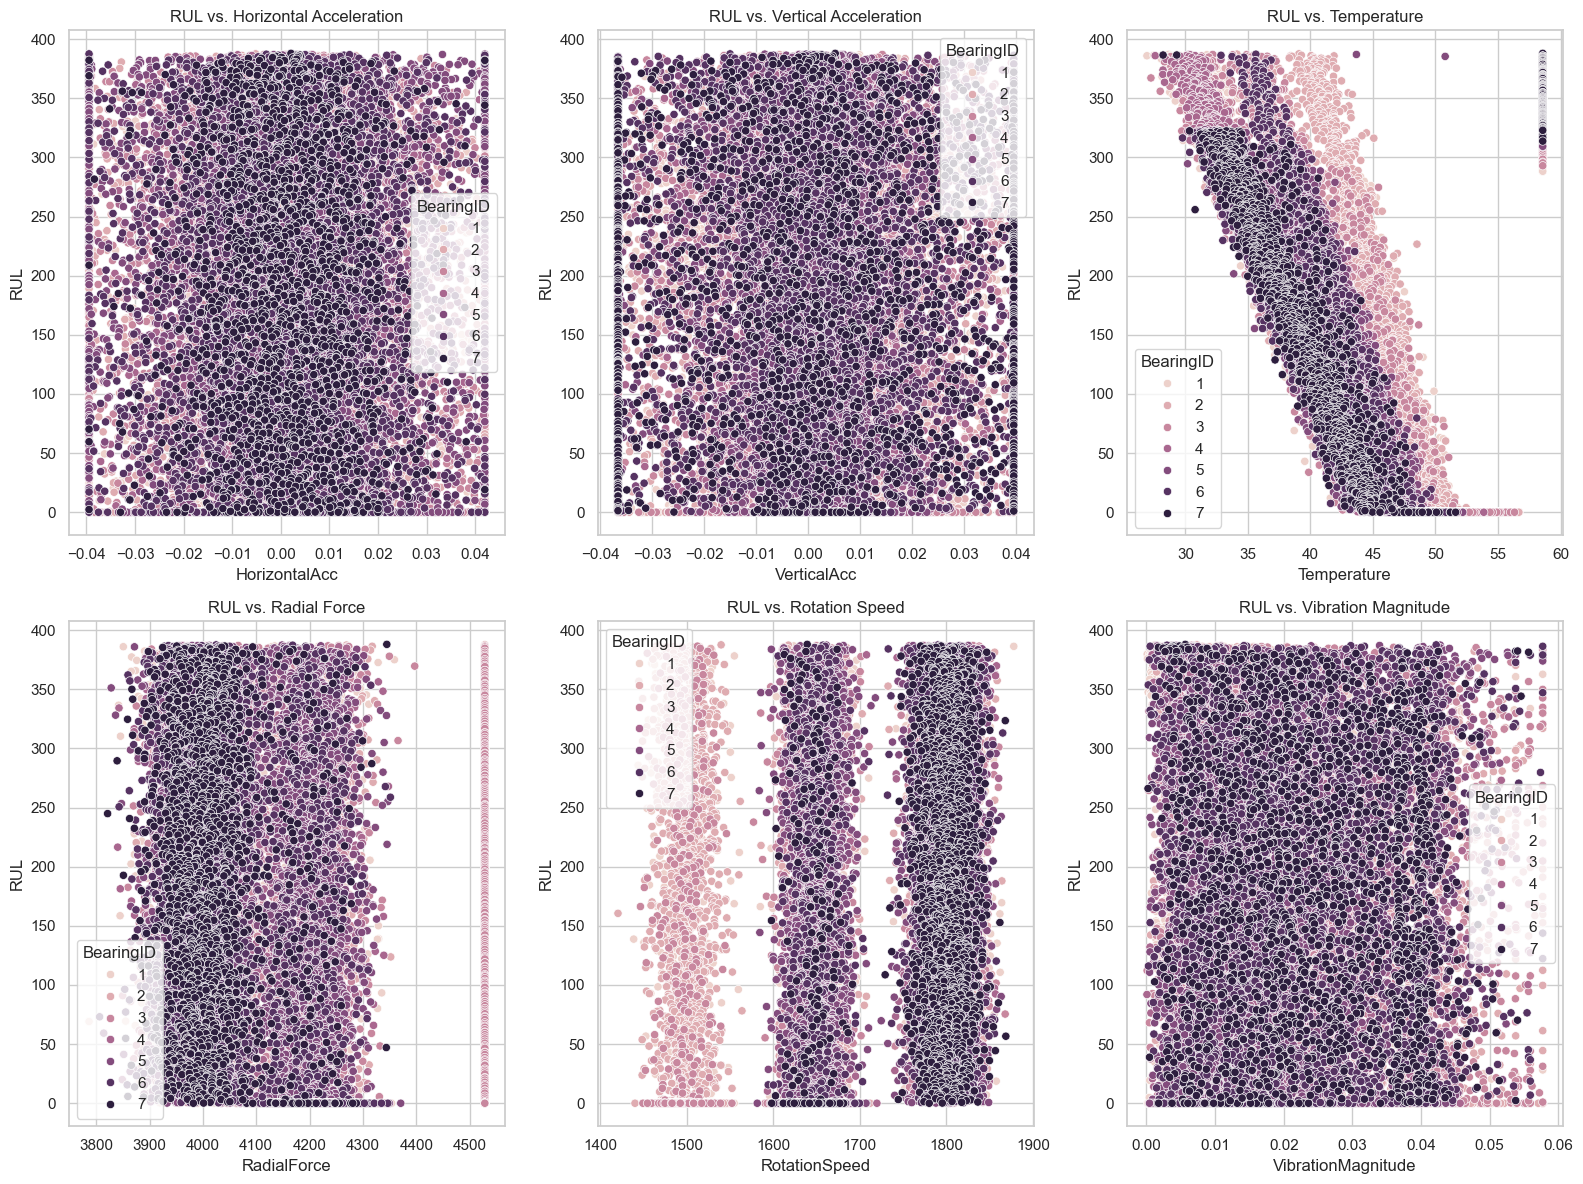

In [7]:
def visualize_data(df):
    """
    Create visualizations for the bearing data.
    
    Parameters:
    df (pd.DataFrame): DataFrame with features and RUL values
    """
    if df is None or df.empty:
        print("No data for visualization")
        return
    
    # Convert Timestamp to datetime for plotting
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    
    # 1. Plot RUL over time for each bearing
    plt.figure(figsize=(14, 8))
    for bearing_id, group in df.groupby('BearingID'):
        plt.plot(group['Timestamp'], group['RUL'], marker='o', linestyle='-', label=f'Bearing {bearing_id}')
    
    plt.title('Remaining Useful Life (RUL) over Time')
    plt.xlabel('Timestamp')
    plt.ylabel('RUL')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # 2. Plot accelerometer data over time
    plt.figure(figsize=(14, 10))
    
    plt.subplot(2, 1, 1)
    for bearing_id, group in df.groupby('BearingID'):
        plt.plot(group['Timestamp'], group['HorizontalAcc'], marker='o', linestyle='-', label=f'Bearing {bearing_id}')
    
    plt.title('Horizontal Acceleration over Time')
    plt.xlabel('Timestamp')
    plt.ylabel('Horizontal Acceleration')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    
    plt.subplot(2, 1, 2)
    for bearing_id, group in df.groupby('BearingID'):
        plt.plot(group['Timestamp'], group['VerticalAcc'], marker='o', linestyle='-', label=f'Bearing {bearing_id}')
    
    plt.title('Vertical Acceleration over Time')
    plt.xlabel('Timestamp')
    plt.ylabel('Vertical Acceleration')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # 3. Plot temperature over time
    plt.figure(figsize=(14, 6))
    for bearing_id, group in df.groupby('BearingID'):
        plt.plot(group['Timestamp'], group['Temperature'], marker='o', linestyle='-', label=f'Bearing {bearing_id}')
    
    plt.title('Temperature over Time')
    plt.xlabel('Timestamp')
    plt.ylabel('Temperature')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # 4. Plot operating conditions over time
    plt.figure(figsize=(14, 12))
    
    plt.subplot(3, 1, 1)
    for bearing_id, group in df.groupby('BearingID'):
        plt.plot(group['Timestamp'], group['RadialForce'], marker='o', linestyle='-', label=f'Bearing {bearing_id}')
    
    plt.title('Radial Force over Time')
    plt.xlabel('Timestamp')
    plt.ylabel('Radial Force')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    
    plt.subplot(3, 1, 2)
    for bearing_id, group in df.groupby('BearingID'):
        plt.plot(group['Timestamp'], group['RotationSpeed'], marker='o', linestyle='-', label=f'Bearing {bearing_id}')
    
    plt.title('Rotation Speed over Time')
    plt.xlabel('Timestamp')
    plt.ylabel('Rotation Speed')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    
    plt.subplot(3, 1, 3)
    for bearing_id, group in df.groupby('BearingID'):
        plt.plot(group['Timestamp'], group['Torque'], marker='o', linestyle='-', label=f'Bearing {bearing_id}')
    
    plt.title('Torque over Time')
    plt.xlabel('Timestamp')
    plt.ylabel('Torque')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # 5. Plot vibration magnitude over time
    if 'VibrationMagnitude' in df.columns:
        plt.figure(figsize=(14, 6))
        for bearing_id, group in df.groupby('BearingID'):
            plt.plot(group['Timestamp'], group['VibrationMagnitude'], marker='o', linestyle='-', label=f'Bearing {bearing_id}')
        
        plt.title('Vibration Magnitude over Time')
        plt.xlabel('Timestamp')
        plt.ylabel('Vibration Magnitude')
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    
    # 6. Correlation heatmap
    plt.figure(figsize=(12, 10))
    
    # Select numeric columns for correlation
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    # Exclude some columns if needed
    exclude_cols = ['BearingID', 'TimeDelta']
    corr_cols = [col for col in numeric_cols if col not in exclude_cols]
    
    corr_matrix = df[corr_cols].corr()
    
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Correlation Matrix')
    plt.tight_layout()
    plt.show()
    
    # 7. Scatter plots of RUL vs. key features
    plt.figure(figsize=(16, 12))
    
    plt.subplot(2, 3, 1)
    sns.scatterplot(data=df, x='HorizontalAcc', y='RUL', hue='BearingID')
    plt.title('RUL vs. Horizontal Acceleration')
    plt.grid(True)
    
    plt.subplot(2, 3, 2)
    sns.scatterplot(data=df, x='VerticalAcc', y='RUL', hue='BearingID')
    plt.title('RUL vs. Vertical Acceleration')
    plt.grid(True)
    
    plt.subplot(2, 3, 3)
    sns.scatterplot(data=df, x='Temperature', y='RUL', hue='BearingID')
    plt.title('RUL vs. Temperature')
    plt.grid(True)
    
    plt.subplot(2, 3, 4)
    sns.scatterplot(data=df, x='RadialForce', y='RUL', hue='BearingID')
    plt.title('RUL vs. Radial Force')
    plt.grid(True)
    
    plt.subplot(2, 3, 5)
    sns.scatterplot(data=df, x='RotationSpeed', y='RUL', hue='BearingID')
    plt.title('RUL vs. Rotation Speed')
    plt.grid(True)
    
    plt.subplot(2, 3, 6)
    if 'VibrationMagnitude' in df.columns:
        sns.scatterplot(data=df, x='VibrationMagnitude', y='RUL', hue='BearingID')
        plt.title('RUL vs. Vibration Magnitude')
    else:
        sns.scatterplot(data=df, x='Torque', y='RUL', hue='BearingID')
        plt.title('RUL vs. Torque')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Convert Timestamp back to string format
    df['Timestamp'] = df['Timestamp'].dt.strftime('%m/%d/%Y %H:%M')

# Visualize the data if features are available
if 'features_data' in locals() and features_data is not None:
    visualize_data(features_data)

## 7. Model Training for RUL Prediction

In this section, we'll train machine learning models to predict the Remaining Useful Life (RUL) based on the sensor data.

ℹ️ Dropping non‑numeric columns: ['Timestamp']
Training Random Forest...
Random Forest - RMSE: 10.4090, MAE: 5.4855, R²: 0.9925
Training Gradient Boosting...
Gradient Boosting - RMSE: 20.5219, MAE: 15.1686, R²: 0.9707
Training XGBoost...
XGBoost - RMSE: 8.6224, MAE: 5.6146, R²: 0.9948


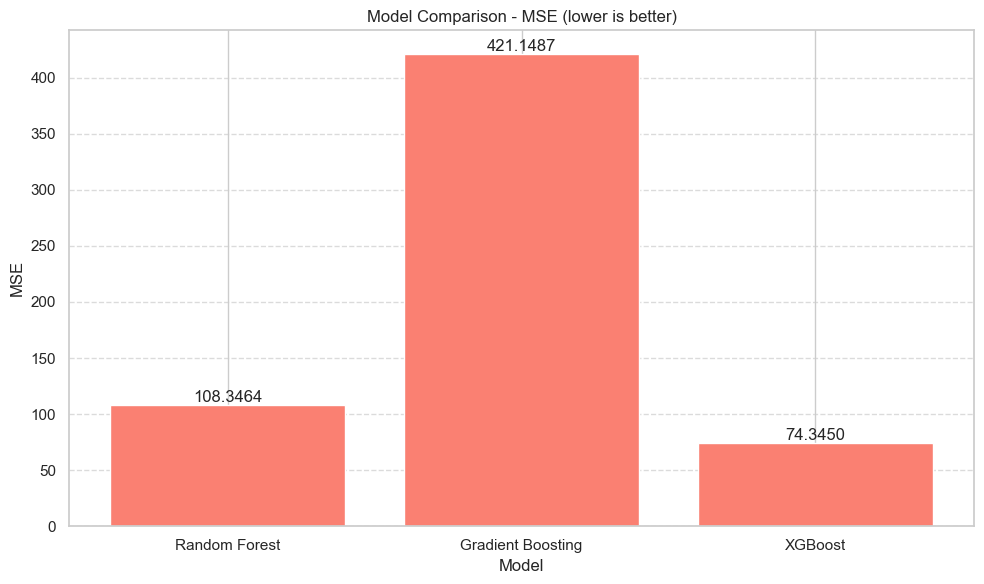

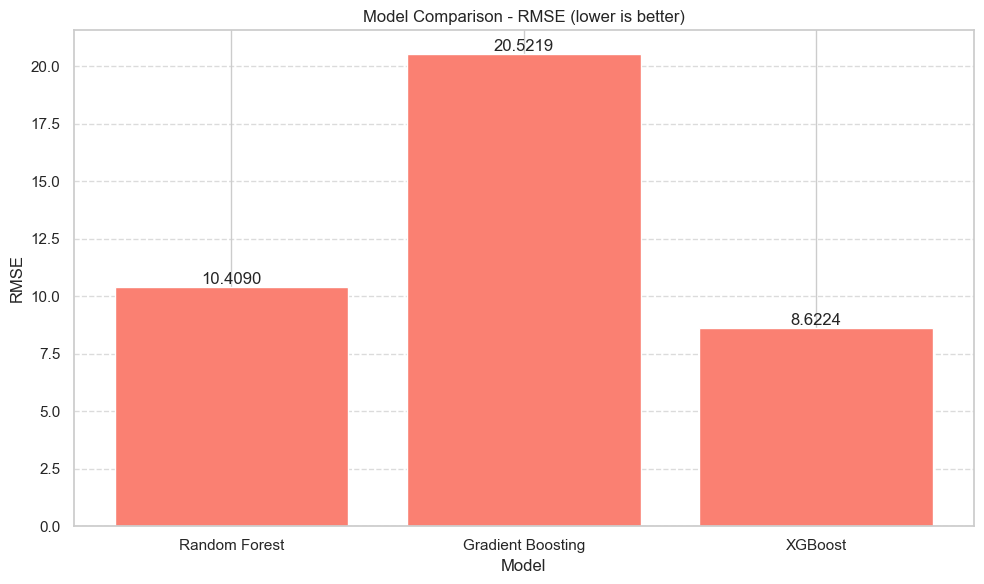

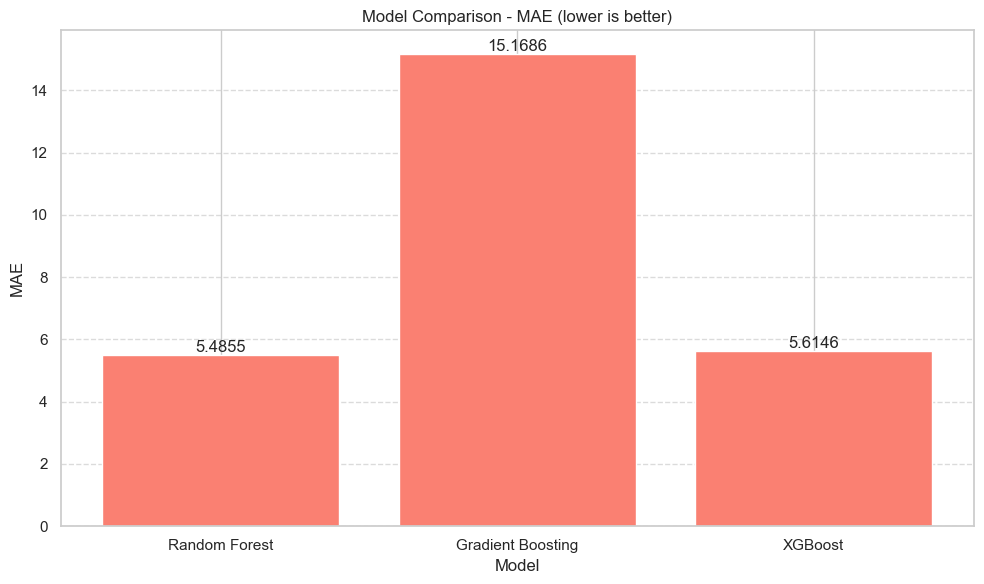

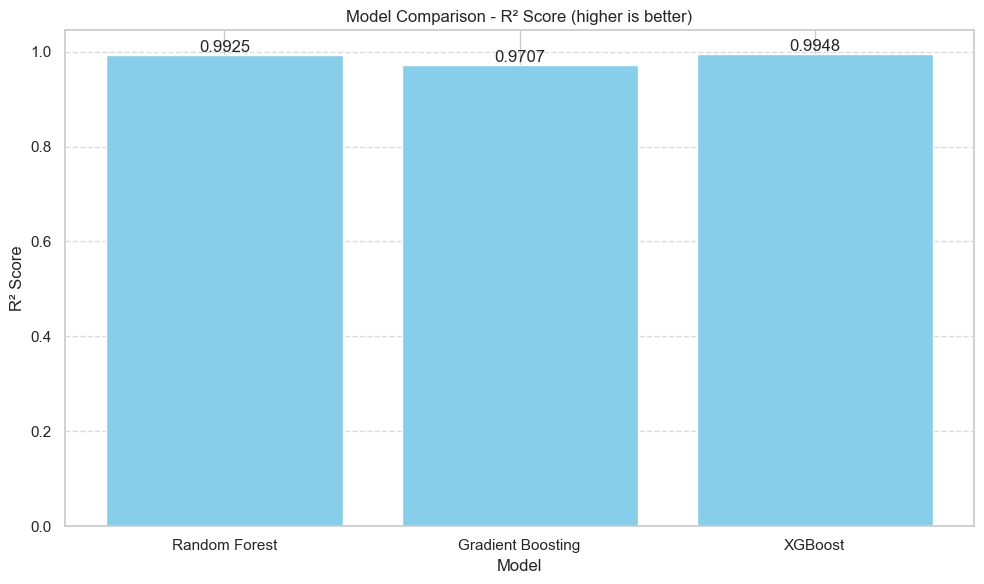

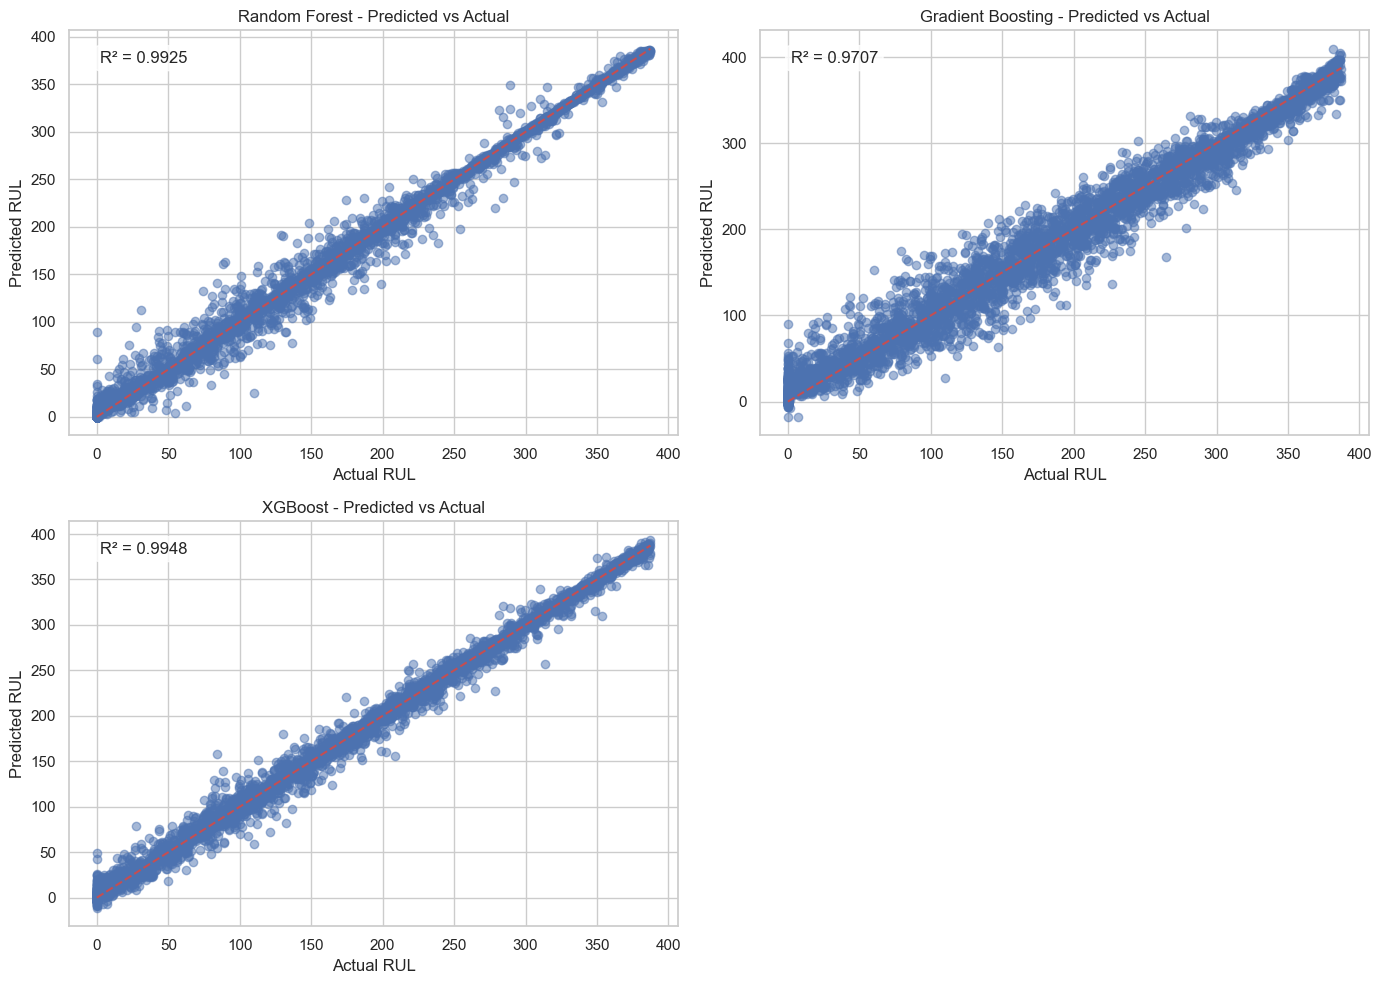

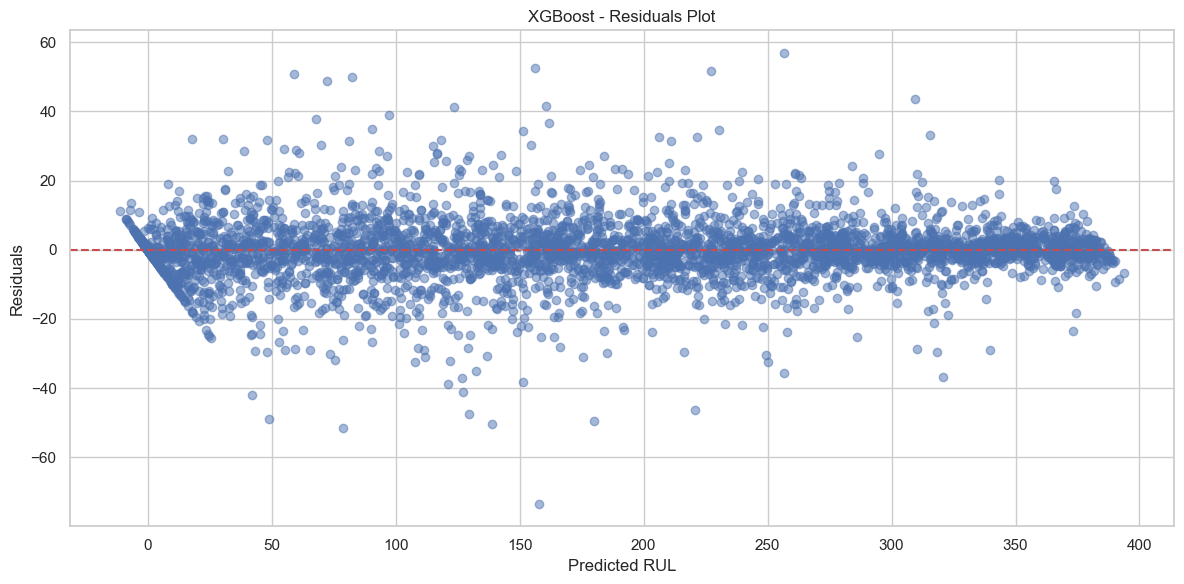

In [8]:

def prepare_data_for_modeling(df, target_col="RUL", test_size=0.2, random_state=42):
    # 1) Separate features & target
    X = df.drop(columns=[target_col])
    y = df[target_col]

    # 2) Drop non-numeric columns (e.g. timestamps)
    numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    dropped = list(set(X.columns) - set(numeric_cols))
    if dropped:
        print(f"ℹ️ Dropping non‑numeric columns: {dropped}")
    X = X[numeric_cols]

    # 3) Replace infinities with NaN
    X.replace([np.inf, -np.inf], np.nan, inplace=True)

    # 4) Drop columns that are all NaN
    all_nan = [c for c in X.columns if X[c].isna().all()]
    if all_nan:
        print(f"ℹ️ Dropping all‑NaN cols: {all_nan}")
        X.drop(columns=all_nan, inplace=True)

    # 5) Impute remaining NaNs with medians
    medians = X.median(numeric_only=True)
    X.fillna(medians, inplace=True)

    # 6) Clip extreme outliers to the 1st–99th percentile
    for c in X.columns:
        low, high = X[c].quantile([0.01, 0.99])
        X[c] = X[c].clip(low, high)

    # 7) Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # 8) Scale
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test)

    feature_names = X_train.columns.tolist()
    return X_train_scaled, X_test_scaled, y_train, y_test, scaler, feature_names


def train_and_evaluate_models(X_train, X_test, y_train, y_test, feature_names=None):
    """
    Train and evaluate multiple models for RUL prediction.
    
    Parameters:
    X_train, X_test, y_train, y_test: Training and testing data
    feature_names: List of feature names for feature importance plots
    
    Returns:
    dict: Dictionary of trained models and their performance metrics
    """
    if X_train is None or X_test is None or y_train is None or y_test is None:
        print("No data for model training")
        return None
    
    # Define models to train
    models = {
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
        'XGBoost': XGBRegressor(n_estimators=100, random_state=42)
    }
    
    # Train and evaluate each model
    results = {}
    
    for name, model in models.items():
        print(f"Training {name}...")
        # Train the model
        model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        print(f"{name} - RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")
        
        # Store results
        results[name] = {
            'model': model,
            'mse': mse,
            'rmse': rmse,
            'mae': mae,
            'r2': r2,
            'predictions': y_pred,
            'feature_names': feature_names
        }
    
    return results

def visualize_model_results(results, y_test):
    """
    Visualize the results of the trained models.
    
    Parameters:
    results (dict): Dictionary of model results
    y_test: True target values
    """
    if results is None or y_test is None:
        print("No results to visualize")
        return
    
    # 1. Compare model performance metrics
    metrics = ['mse', 'rmse', 'mae', 'r2']
    model_names = list(results.keys())
    
    for metric in metrics:
        plt.figure(figsize=(10, 6))
        values = [results[name][metric] for name in model_names]
        
        if metric == 'r2':
            # Higher R² is better
            bars = plt.bar(model_names, values, color='skyblue')
            plt.title(f'Model Comparison - R² Score (higher is better)')
            plt.ylabel('R² Score')
        else:
            # Lower error metrics are better
            bars = plt.bar(model_names, values, color='salmon')
            plt.title(f'Model Comparison - {metric.upper()} (lower is better)')
            plt.ylabel(metric.upper())
        
        # Add value labels on top of bars
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.4f}',
                    ha='center', va='bottom', rotation=0)
        
        plt.xlabel('Model')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
    
    # 2. Plot predicted vs actual values for each model
    plt.figure(figsize=(14, 10))
    
    for i, (name, result) in enumerate(results.items(), 1):
        plt.subplot(2, 2, i)
        
        plt.scatter(y_test, result['predictions'], alpha=0.5)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
        
        plt.title(f'{name} - Predicted vs Actual')
        plt.xlabel('Actual RUL')
        plt.ylabel('Predicted RUL')
        plt.grid(True)
        
        # Add R² value to the plot
        plt.text(0.05, 0.95, f"R² = {result['r2']:.4f}", transform=plt.gca().transAxes,
                fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # 3. Plot residuals for the best model
    best_model_name = max(results, key=lambda x: results[x]['r2'])
    best_result = results[best_model_name]
    
    plt.figure(figsize=(12, 6))
    
    residuals = y_test - best_result['predictions']
    
    plt.scatter(best_result['predictions'], residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    
    plt.title(f'{best_model_name} - Residuals Plot')
    plt.xlabel('Predicted RUL')
    plt.ylabel('Residuals')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
   

# Prepare data for modeling if features are available
if 'features_data' in locals() and features_data is not None:
    X_train, X_test, y_train, y_test, scaler, feature_names = prepare_data_for_modeling(features_data)
    
    if X_train is not None and y_train is not None:
        # Train and evaluate models
        model_results = train_and_evaluate_models(X_train, X_test, y_train, y_test, feature_names)
        
        # Visualize model results
        if model_results is not None:
            visualize_model_results(model_results, y_test)

## 8. Save the Processed Data

Save the processed data with RUL values to a CSV file for future use.

In [9]:
# Save the processed data to a CSV file
if 'features_data' in locals() and features_data is not None:
    # Keep only the columns that match the example format
    columns_to_keep = ['BearingID', 'Timestamp', 'RadialForce', 'RotationSpeed', 'Torque', 
                       'HorizontalAcc', 'VerticalAcc', 'Temperature', 'RUL']
    
    # Filter columns that exist in the DataFrame
    existing_columns = [col for col in columns_to_keep if col in features_data.columns]
    
    # Create a new DataFrame with only the required columns
    final_data = features_data[existing_columns].copy()
    
    # Save to CSV
    output_file = "processed_bearing_rul_data.csv"
    final_data.to_csv(output_file, index=False)
    print(f"Processed data saved to '{output_file}'")
    
    # Display the first few rows of the final data
    final_data.head()

Processed data saved to 'processed_bearing_rul_data.csv'


## 9. Conclusion

In this notebook, we've demonstrated how to process the FEMTO bearing dataset from the IEEE PHM 2012 Prognostic Challenge. We've implemented data loading, preprocessing, feature engineering to calculate RUL, visualization, and model training for bearing failure prediction.

The key steps in the process were:

1. Combining accelerometer and temperature data from multiple bearing folders into a single dataset
2. Preprocessing the data to handle missing values and outliers
3. Extracting features from the raw sensor data
4. Visualizing the data to understand the relationships between different features and RUL
5. Training and evaluating machine learning models to predict RUL

The best performing model can be used to predict the RUL of bearings based on their sensor data, enabling proactive maintenance and reducing downtime.